In [ ]:
!pip install contractions beautifulsoup4 scikit-learn transformers torch pandas numpy nltk joblib "accelerate>=0.21.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import contractions
from bs4 import BeautifulSoup
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput
import joblib


try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
try:
    train_df = pd.read_csv('emotion-labels-train.csv')
    val_df = pd.read_csv('emotion-labels-val.csv')
    test_df = pd.read_csv('emotion-labels-test.csv')
    print("Train, validation, and test files loaded successfully.")
    print(f"Train samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
except FileNotFoundError:
    print("Error: Dataset files not found. Creating dummy data for demonstration.")


Train, validation, and test files loaded successfully.
Train samples: 3613
Validation samples: 347
Test samples: 3142


In [ ]:
# Preprocessing functions
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', ' ', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    document = strip_html_tags(document)
    document = document.lower()
    document = expand_contractions(document)
    document = remove_accented_chars(document)
    document = remove_special_characters(document, remove_digits=True)
    return document


In [ ]:
# Apply preprocessing to each split
print("\nApplying preprocessing to all data splits...")
for df in [train_df, val_df, test_df]:
    df['cleaned_text'] = df['text'].apply(pre_process_document)

# Label Encoding
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
val_df['label_encoded'] = le.transform(val_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

# Prepare data for tokenization
X_train, y_train = train_df['cleaned_text'].tolist(), train_df['label_encoded'].tolist()
X_val, y_val = val_df['cleaned_text'].tolist(), val_df['label_encoded'].tolist()
X_test, y_test = test_df['cleaned_text'].tolist(), test_df['label_encoded'].tolist()

print("\nData preprocessing complete.")
print(f"Labels: {list(le.classes_)}")
num_labels = len(le.classes_)



Applying preprocessing to all data splits...

Data preprocessing complete.
Labels: ['anger', 'fear', 'joy', 'sadness']


In [ ]:
MODEL_NAME = "vinai/bertweet-base"
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME, normalization=True)

train_encodings = tokenizer_bert(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer_bert(X_val, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer_bert(X_test, truncation=True, padding=True, max_length=128)


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
test_dataset = EmotionDataset(test_encodings, y_test)

In [ ]:
class BERTweetBiLSTMClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BERTweetBiLSTMClassifier, self).__init__()
        self.num_labels = num_labels

        # Load pretrained BERTweet
        self.bertweet = AutoModel.from_pretrained(MODEL_NAME, return_dict=True)

        # 🔹 Bidirectional 2-layer LSTM
        self.lstm = nn.LSTM(
            input_size=self.bertweet.config.hidden_size,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(256 * 2, num_labels)  # 512-dim from BiLSTM

    def forward(self, input_ids, attention_mask, labels=None):
        # BERTweet embeddings
        bert_outputs = self.bertweet(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state  # (batch, seq_len, hidden)

        # LSTM forward pass
        _, (hidden_state, _) = self.lstm(sequence_output)

        # Concatenate forward & backward hidden states from last LSTM layer
        forward_last = hidden_state[-2, :, :]
        backward_last = hidden_state[-1, :, :]
        lstm_output = torch.cat((forward_last, backward_last), dim=1)

        # Classification head
        dropped_output = self.dropout(lstm_output)
        logits = self.classifier(dropped_output)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(loss=loss, logits=logits)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    fp16=True,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    disable_tqdm=False
)

print("\nInitializing BERTweet+LSTM model...")
model_bert_lstm = BERTweetBiLSTMClassifier(num_labels=num_labels)



Initializing BERTweet+LSTM model...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

trainer_lstm = Trainer(
    model=model_bert_lstm,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)




print("\nTraining BERTweet+LSTM model...")
trainer_lstm.train()

/tmp/ipython-input-2285259760.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lstm = Trainer(



Training BERTweet+LSTM model...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: paradox117 (paradox117-jadavpur-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.378100,1.368786,0.317003,0.152605
2,1.222300,0.849740,0.804035,0.802462
3,0.581200,0.476901,0.841499,0.842673
4,0.364300,0.434310,0.873199,0.872829
5,0.270200,0.411929,0.864553,0.865141
6,0.221200,0.452905,0.876081,0.876002
7,0.134100,0.513979,0.864553,0.864783
8,0.098900,0.603435,0.864553,0.865644
9,0.080600,0.595970,0.867435,0.867884


TrainOutput(global_step=1017, training_loss=0.47774183251982005, metrics={'train_runtime': 315.0849, 'train_samples_per_second': 114.667, 'train_steps_per_second': 3.586, 'total_flos': 0.0, 'train_loss': 0.47774183251982005, 'epoch': 9.0})

In [ ]:
print("\nEvaluating BERTweet+LSTM on validation set...")
val_results_lstm = trainer_lstm.evaluate(eval_dataset=val_dataset)
print("\nValidation Results (BERTweet+LSTM):")
for key, value in val_results_lstm.items():
    print(f"{key}: {value:.4f}")

print("\nEvaluating BERTweet+LSTM on test set...")
test_results_lstm = trainer_lstm.evaluate(eval_dataset=test_dataset)
print("\nTest Results (BERTweet+LSTM):")
for key, value in test_results_lstm.items():
    print(f"{key}: {value:.4f}")



Evaluating BERTweet+LSTM on validation set...



Validation Results (BERTweet+LSTM):
eval_loss: 0.4529
eval_accuracy: 0.8761
eval_f1: 0.8760
eval_runtime: 0.3515
eval_samples_per_second: 987.1870
eval_steps_per_second: 17.0700
epoch: 9.0000

Evaluating BERTweet+LSTM on test set...

Test Results (BERTweet+LSTM):
eval_loss: 0.4303
eval_accuracy: 0.8733
eval_f1: 0.8734
eval_runtime: 3.6754
eval_samples_per_second: 854.8630
eval_steps_per_second: 13.6040
epoch: 9.0000


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths in your Drive
drive_base_path = "/content/drive/MyDrive/bertweet-bilstm"
os.makedirs(drive_base_path, exist_ok=True)

bert_bilstm_path = os.path.join(drive_base_path, "bertweet-bilstm-emotion-model")
label_encoder_path = os.path.join(drive_base_path, "label_encoder.pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save BERTweet+LSTM
trainer_lstm.save_model(bert_gru_path)
tokenizer_bert.save_pretrained(bert_gru_path)

# Save Label Encoder
joblib.dump(le, label_encoder_path)

print(f"Models and label encoder saved to Google Drive at '{drive_base_path}'")


Models and label encoder saved to Google Drive at '/content/drive/MyDrive/bertweet-bilstm'


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def get_preds_labels(model, dataset):
    """Get predicted labels and true labels for a dataset"""
    model.eval()
    preds = []
    labels = []
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(model.bertweet.device)
            attention_mask = batch['attention_mask'].to(model.bertweet.device)
            label = batch['labels'].to(model.bertweet.device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1)

            preds.extend(batch_preds.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return np.array(preds), np.array(labels)

def plot_conf_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


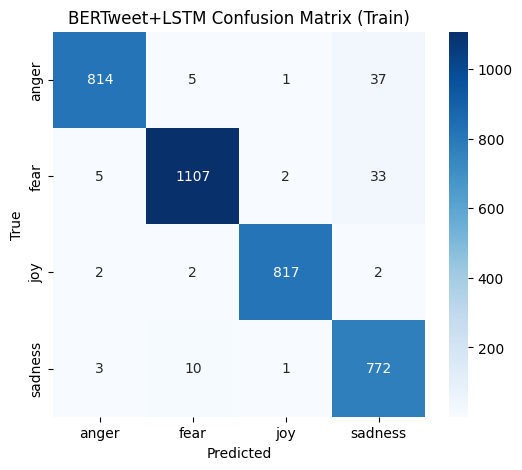

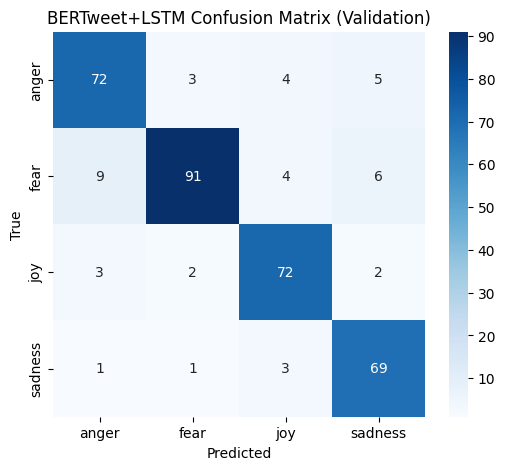

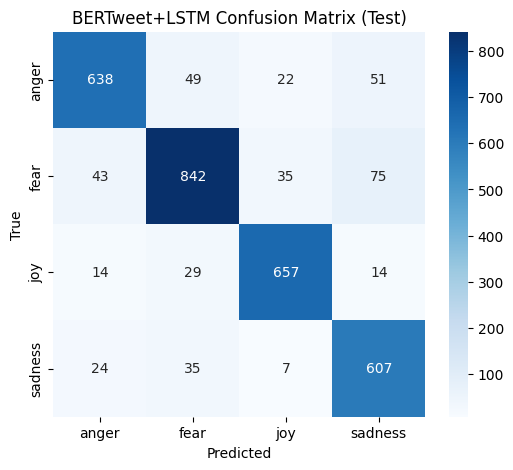

In [ ]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model_bert_lstm.to(device)

datasets = {"Train": train_dataset, "Validation": val_dataset, "Test": test_dataset}

for split_name, dataset in datasets.items():
    preds, labels_true = get_preds_labels(model_bert_lstm, dataset)
    plot_conf_matrix(labels_true, preds, f"BERTweet+LSTM Confusion Matrix ({split_name})", le.classes_)